In [1]:
%matplotlib inline
import sys
from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../")
    
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib.utils.draw import show_policy_black,show_value_function
import matplotlib


env = BlackjackEnv()

In [2]:
def get_epsilon_policy(Q,nA,epsilon):
    
    def policy_fn(observation):
        A = np.ones(nA) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1 - epsilon)
        return A
    return policy_fn

In [3]:
def on_policy_first_visit_episode(env,num_episodes,gamma=1.0,epsilon=0.1):
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    policy = get_epsilon_policy(Q,env.nA,epsilon)
    
    for i_episode in range(num_episodes):
        if i_episode % 1000 == 0:
            print(f"\rEpisode :{i_episode/num_episodes * 100:.2f}%",end = "")
            sys.stdout.flush()
        
        state = env.reset()
        stack_state_action = []
        stack_reward = []
        
        while True:
            probs = policy(state)
            action = np.random.choice( range(len(probs)), p=probs )
            next_state, reward, done,_ = env.step(action)
            stack_state_action.append( (state,action) )
            stack_reward.append(reward)
            if done:
                break
            state = next_state
        size = len(stack_state_action)
        G = 0
        for i in range(size-1,-1,-1):
            state, action = stack_state_action[i]
            state = tuple(state)
            key = (state, action)
            
            G = gamma * G + stack_reward[i]
            if stack_state_action[i] not in stack_state_action[0:i]:
                returns_sum[key] += G
                returns_count[key] += 1
                Q[state][action] =  returns_sum[key] / returns_count[key]
    return Q,policy
    

In [4]:
Q, policy = on_policy_first_visit_episode(env,num_episodes=500000,gamma=1.0,epsilon=0.1)

Episode :99.80%

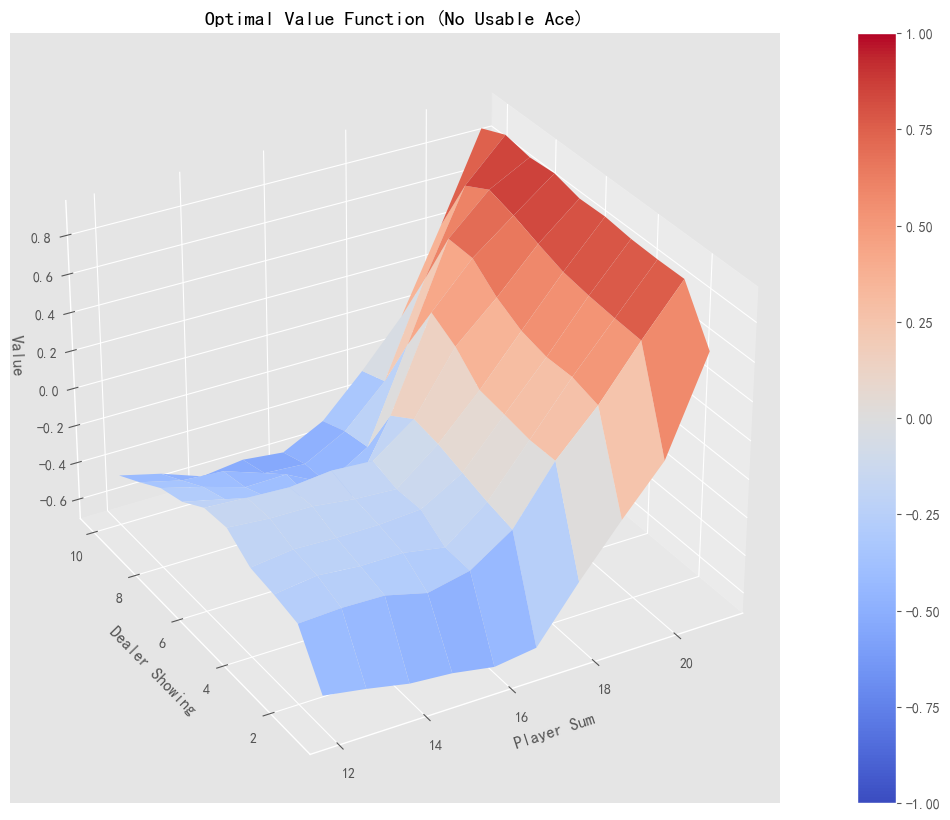

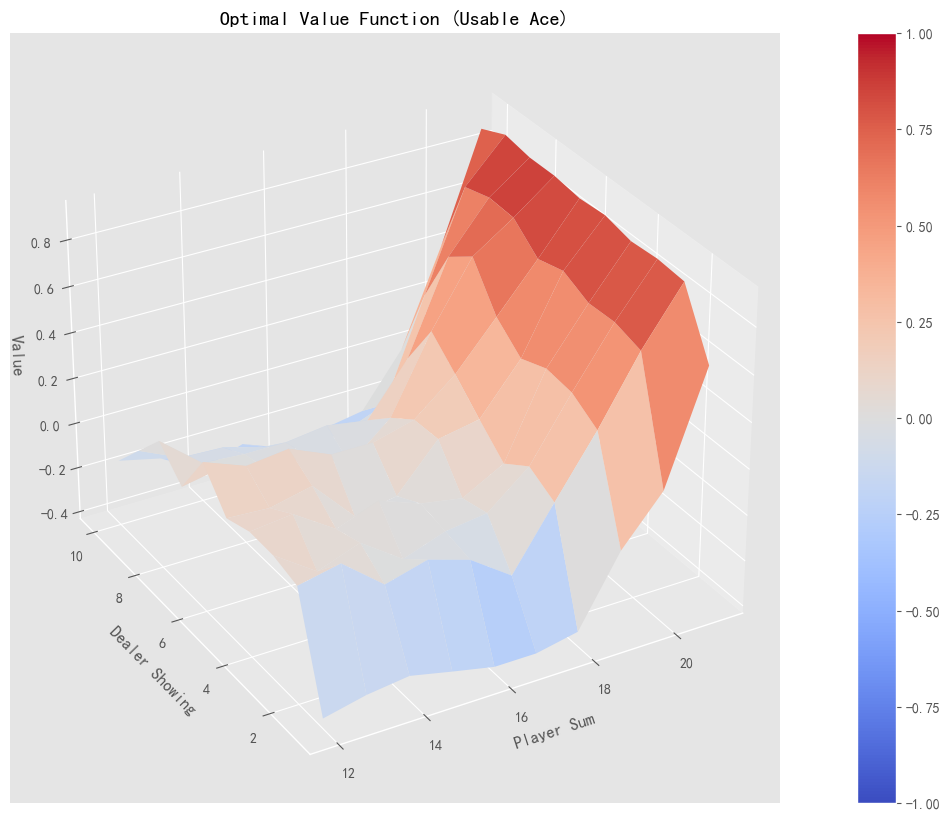

In [5]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
show_value_function(V, title="Optimal Value Function")

[[1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


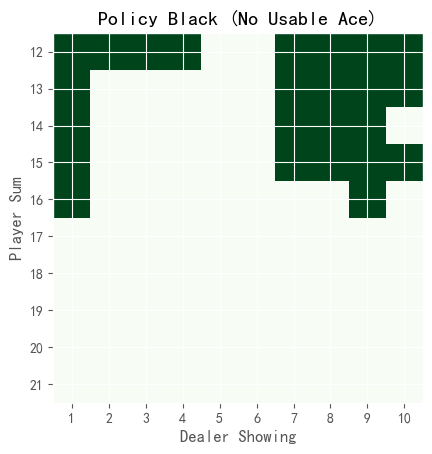

In [6]:

show_policy_black(policy,V)